### Importing required libraries

In [1]:
%matplotlib inline

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
from ipywidgets import FloatProgress
from IPython.display import display
import scipy.stats as stats
from sklearn import cross_validation
from sklearn import linear_model



### Importing data

In [5]:
#data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution

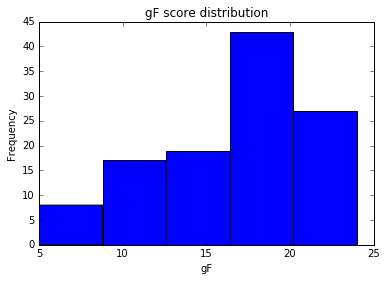

5

In [6]:
n_bins = 5
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(5,50,5)) 

### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

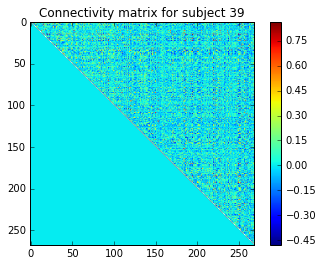

In [8]:
#conn_mats = data['rest_1_mat']
conn_mats = data['rest_2_mat']
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]
    

### Test
Reproducing the work of [Finn et al](http://www.nature.com/neuro/journal/v18/n11/full/nn.4135.html), in a Leave-one-out cross validation (LOOCV) loop, only the edges with a significant correlation with the gF score (on training data) are selected and a statistic (network strengh) is computed on them; then  a first-degree polynomial is fit to model the relation between the statistic and the behavioural variable and it's used to predict the score on the test subject.
Two separate models are built for negatively and positively correlated edges.

In [129]:
# for each edge returns rho and p-value
pears = [stats.pearsonr(edges[:,i],gF) for i in range(0,n_edges)]
#pears = np.apply_along_axis(lambda row: stats.pearsonr(row,gF),0,edges)


In [9]:


loo = cross_validation.LeaveOneOut(n_subj)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subj,1])
errors_neg = np.zeros([n_subj,1])
predictions_pos = np.zeros([n_subj,1])
predictions_neg = np.zeros([n_subj,1])

def regress(p,score,edges):
    i=0
    f = FloatProgress(min=0, max=n_subj)
    display(f)
    for train_index, test_index in loo:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # compute network statistic for each subject in training
        strength_pos = filtered_pos.sum(axis=1) 
        strength_neg = filtered_neg.sum(axis=1)
        # compute network statistic for test subject
        str_pos_test = edges[test_index,idx_filtered_pos].sum()
        str_neg_test = edges[test_index,idx_filtered_neg].sum()
        # regression
        lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
        predictions_pos[i] = lr_pos.predict(str_pos_test)
        lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
        predictions_neg[i] = lr_neg.predict(str_neg_test) 
        errors_pos[i] = abs(predictions_pos[i]-gF[test_index])
        errors_neg[i] = abs(predictions_neg[i]-gF[test_index])
        i=i+1
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges),continuous_update=False)

regress(0.01,gF,edges)


### Results

In [7]:
print('Mean error positive model:',np.mean(errors_pos))
print('Mean error negative model:',np.mean(errors_neg))

print(predictions_pos.transpose())
print(predictions_neg.transpose())
print(gF)

Mean error positive model: 3.95512116501
Mean error negative model: 3.55742357591
[[ 15.42455022  15.92804915  17.67542116  16.94641646  14.33141947
   16.98282207  18.48335302  17.42210647  12.86594712  16.05615324
   16.03655317  17.50902728  13.46892254  18.08687408  16.95073203
   14.15423364  18.35702997  16.5344672   17.43564037  20.71128006
   20.62990759  15.34675054  23.32162676  23.12813252  14.981646
   13.80575402  18.91230023  20.42165833  16.02863052  17.97131785
   17.82293635  17.86351037  15.86433357  18.08121913  16.93620743
   17.03680483  20.78064504  12.2633617   15.19802977  18.19130057
   16.30898218  15.68329807  13.21041519  13.33753331  14.71196272
   15.95469996  15.36681071  16.1504594   17.29480407  14.49208947
   15.8652505   15.50482914  16.74293765  15.84662518  15.60441188
   13.63082166  16.70302724  16.60547627  15.32868992  14.21351863
   15.45413629  15.44629722  18.50701734  17.68518807  16.74127678
   15.75811846  15.62921207  14.32730075  13.9486

### Plot Rest Session 1

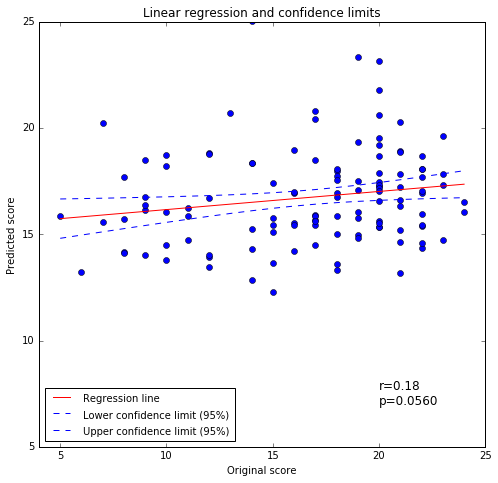

In [9]:


x = np.ravel(gF)
y = np.ravel(predictions_pos)


# fit a curve to the data using a least squares 1st order polynomial fit
z = np.polyfit(x,y,1)

p = np.poly1d(z)
fit = p(x)
 
# get the coordinates for the fit curve
c_x = [np.min(x),np.max(x)]
c_y = p(c_x)
 
# predict y values of origional data using the fit
p_y = z[0] * x + z[1]
 
# calculate the y-error (residuals)
y_err = y - p_y
 
# create series of new test x-values to predict for
p_x = np.arange(np.min(x),np.max(x)+1,1)
 
# now calculate confidence intervals for new test x-series
mean_x = np.mean(x)         # mean of x
n = len(x)              # number of samples in origional fit
DF = n_subj - z.size                            # degrees of freedom
t = stats.t.ppf(0.95, DF)           # used for CI and PI bands
s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals
 
#confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
# now predict y based on test x-values
p_y = z[0]*p_x+z[1]
 
# get lower and upper confidence limits based on predicted y and confidence intervals
lower = p_y - abs(confs)
upper = p_y + abs(confs)
 
# set-up the plot
plt.subplots(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.xlabel('Original score')
plt.ylabel('Predicted score')
plt.title('Linear regression and confidence limits')
 
# plot sample data
plt.plot(x,y,'bo')
 
# plot line of best fit
plt.plot(c_x,c_y,'r-',label='Regression line')
 
# plot confidence limits
plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')
 
# set coordinate limits
plt.xlim(4,25)
plt.ylim(5,25)
 
# configure legend
plt.legend(loc=0)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=10)

# add text
rho,p = stats.pearsonr(np.ravel(predictions_pos),gF)
s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
plt.text(20, 7, s, fontsize=12)
 
# show the plot
plt.show()

### Plot Rest Session 2

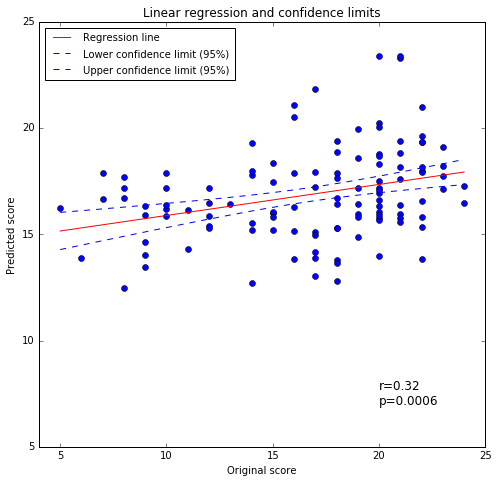

In [10]:


x = np.ravel(gF)
y = np.ravel(predictions_pos)


# fit a curve to the data using a least squares 1st order polynomial fit
z = np.polyfit(x,y,1)

p = np.poly1d(z)
fit = p(x)
 
# get the coordinates for the fit curve
c_x = [np.min(x),np.max(x)]
c_y = p(c_x)
 
# predict y values of origional data using the fit
p_y = z[0] * x + z[1]
 
# calculate the y-error (residuals)
y_err = y - p_y
 
# create series of new test x-values to predict for
p_x = np.arange(np.min(x),np.max(x)+1,1)
 
# now calculate confidence intervals for new test x-series
mean_x = np.mean(x)         # mean of x
n = len(x)              # number of samples in origional fit
DF = n_subj - z.size                            # degrees of freedom
t = stats.t.ppf(0.95, DF)           # used for CI and PI bands
s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals
 
#confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
# now predict y based on test x-values
p_y = z[0]*p_x+z[1]
 
# get lower and upper confidence limits based on predicted y and confidence intervals
lower = p_y - abs(confs)
upper = p_y + abs(confs)
 
# set-up the plot
plt.subplots(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.xlabel('Original score')
plt.ylabel('Predicted score')
plt.title('Linear regression and confidence limits')
 
# plot sample data
plt.plot(x,y,'bo')
 
# plot line of best fit
plt.plot(c_x,c_y,'r-',label='Regression line')
 
# plot confidence limits
plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')
 
# set coordinate limits
plt.xlim(4,25)
plt.ylim(5,25)
 
# configure legend
plt.legend(loc=0)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=10)

# add text
rho,p = stats.pearsonr(np.ravel(predictions_pos),gF)
s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
plt.text(20, 7, s, fontsize=12)
 
# show the plot
plt.show()

Finn et al. obtained *r* = 0.5